# Zillow Zestimate Prediction

Miloy Ajmera (majmera@andrew.cmu.edu) / 17-634: Applied Machine Learning, Spring 2023

In [72]:
import os
import sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns  # We'll mostly use seaborn, a stats visualization library
import matplotlib.pyplot as plt  # Seaborn wrap Matplotlib for visualization. We'll occasionaly want to make custom changes to the plots.

## Load the Zillow Zestimate Prediction dataset.
Read and prepare the data. Consider how you plan to deal with missing data: will you remove columns, if so, under what conditions? Will you attempt to impute any data?

In [ ]:
filepath = "zillow/"
# Load the dataframes
train_2016 = pd.read_csv(filepath + "train_2016.csv", parse_dates=["transactiondate"], low_memory=False)
train_2017 = pd.read_csv(filepath + "train_2017.csv", parse_dates=["transactiondate"], low_memory=False)
properties_2016 = pd.read_csv(filepath + "properties_2016.csv", low_memory=False)
properties_2017 = pd.read_csv(filepath + "properties_2017.csv", low_memory=False)

In [133]:
# Extract different components of the transaction date (year, month, quarter, and day) and storing them in separate columns

# Train data 2016
train_2016["transactiondate_year"] = train_2016["transactiondate"].dt.year
train_2016["transactiondate_month"] = train_2016["transactiondate"].dt.month
train_2016['transactiondate_quarter'] = train_2016['transactiondate'].dt.quarter
train_2016["transactiondate"] = train_2016["transactiondate"].dt.day

# Train data 2016
train_2017["transactiondate_year"] = train_2017["transactiondate"].dt.year
train_2017["transactiondate_month"] = train_2017["transactiondate"].dt.month
train_2017['transactiondate_quarter'] = train_2017['transactiondate'].dt.quarter
train_2017["transactiondate"] = train_2017["transactiondate"].dt.day

In [79]:
# Merge train_2016 with properties_2016
data_2016 = pd.merge(train_2016, properties_2016, on='parcelid', how = 'left')

# Merge train_2017 with properties_2017
data_2017 = pd.merge(train_2017, properties_2017, on='parcelid', how = 'left')


In [109]:
# Concatenate data_2016 and data_2017 into a single dataframe
all = pd.concat([data_2016, data_2017],  ignore_index=True)

print(f'All shape: {all.shape}')
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

All shape: (167888, 60)
Train shape: (82265, 60)
Test shape: (85623, 60)


In [132]:
# Print the information of the dataframe
all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 60 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   parcelid                      167888 non-null  int64         
 1   logerror                      167888 non-null  float64       
 2   transactiondate               167888 non-null  datetime64[ns]
 3   airconditioningtypeid         53788 non-null   float64       
 4   architecturalstyletypeid      468 non-null     float64       
 5   basementsqft                  93 non-null      float64       
 6   bathroomcnt                   167854 non-null  float64       
 7   bedroomcnt                    167854 non-null  float64       
 8   buildingclasstypeid           31 non-null      float64       
 9   buildingqualitytypeid         107173 non-null  float64       
 10  calculatedbathnbr             166056 non-null  float64       
 11  decktypeid   

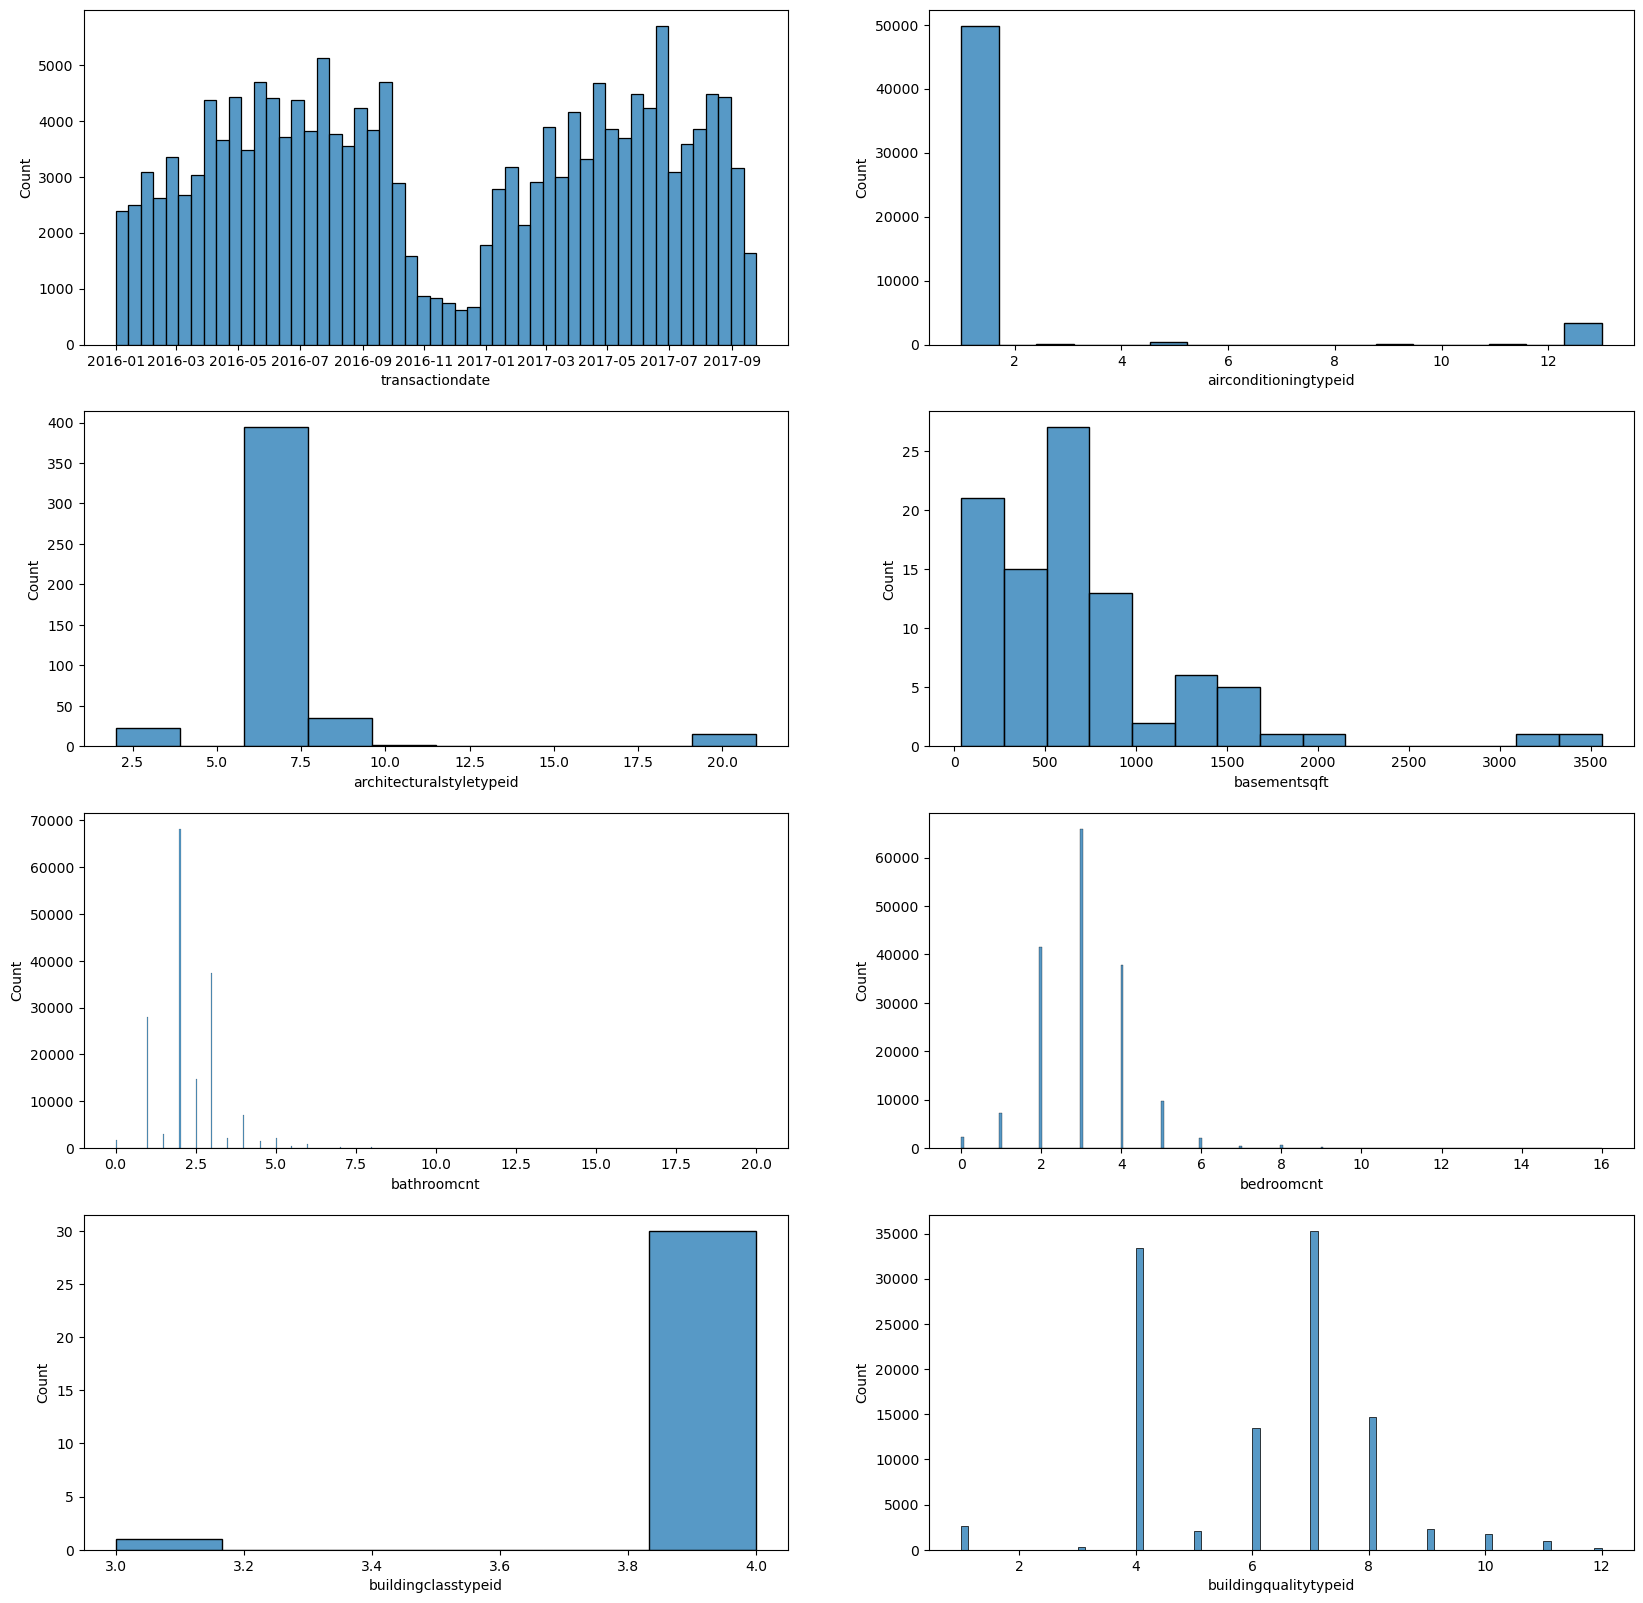

In [128]:
# Let's get a grid of first 8 features up and see what we find.
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))  # Make four rows of 2 plots.
for i, column in enumerate(all.columns[2:10]):
    sns.histplot(data=all, x=column, ax=axes[i // 2, i % 2])  # A bit of arithmatic to assign every figure to the correct subplot (axis).


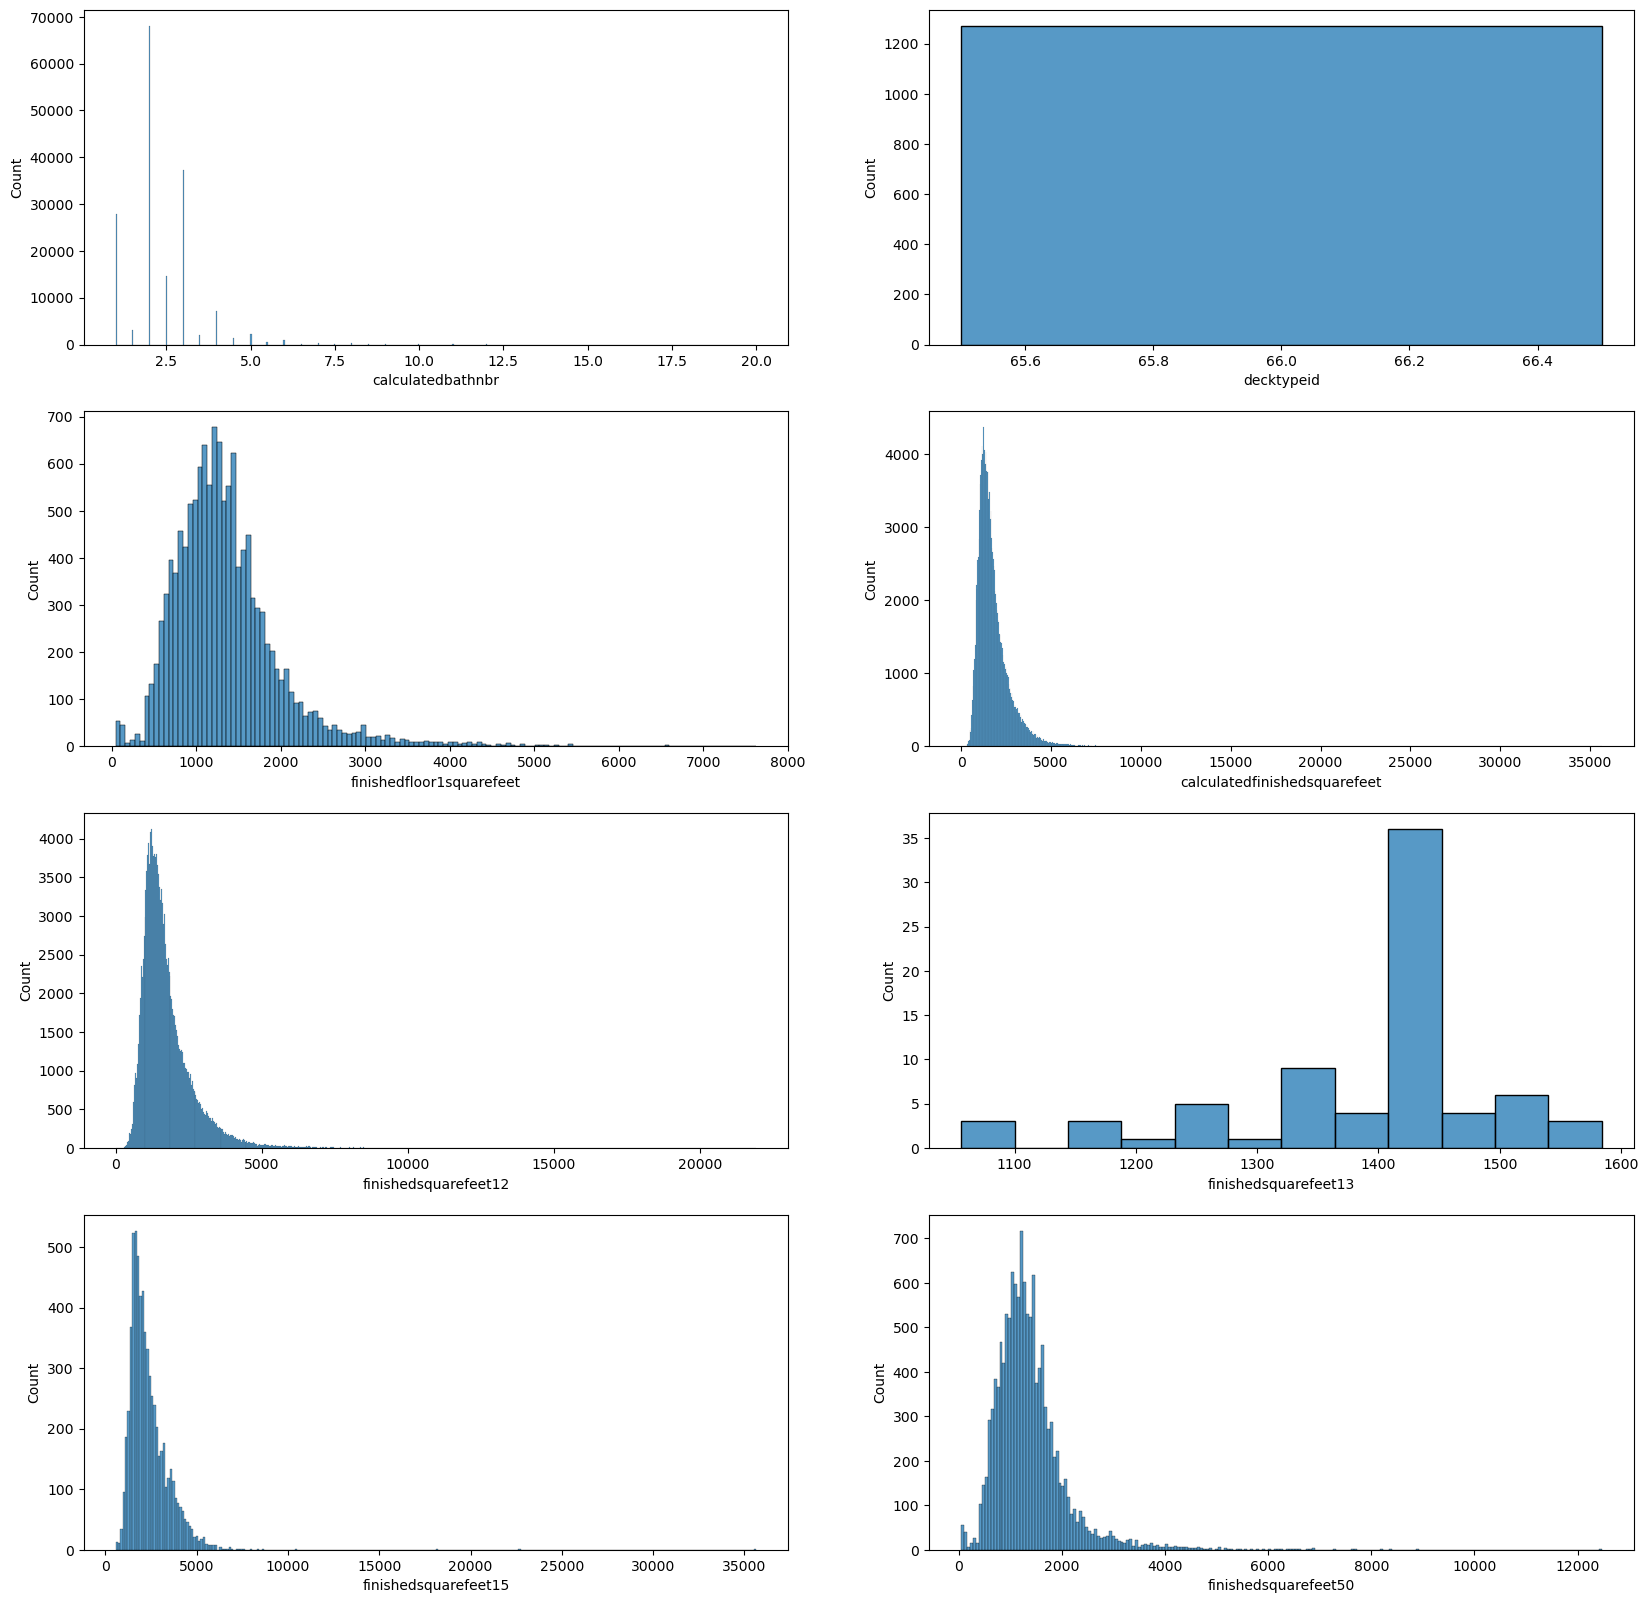

In [129]:
# Let's get a grid of next 8 features up and see what we find.
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))  # Make four rows of 2 plots.
for i, column in enumerate(all.columns[10:18]):
    sns.histplot(data=all, x=column, ax=axes[i // 2, i % 2])  # A bit of arithmatic to assign every figure to the correct subplot (axis).


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

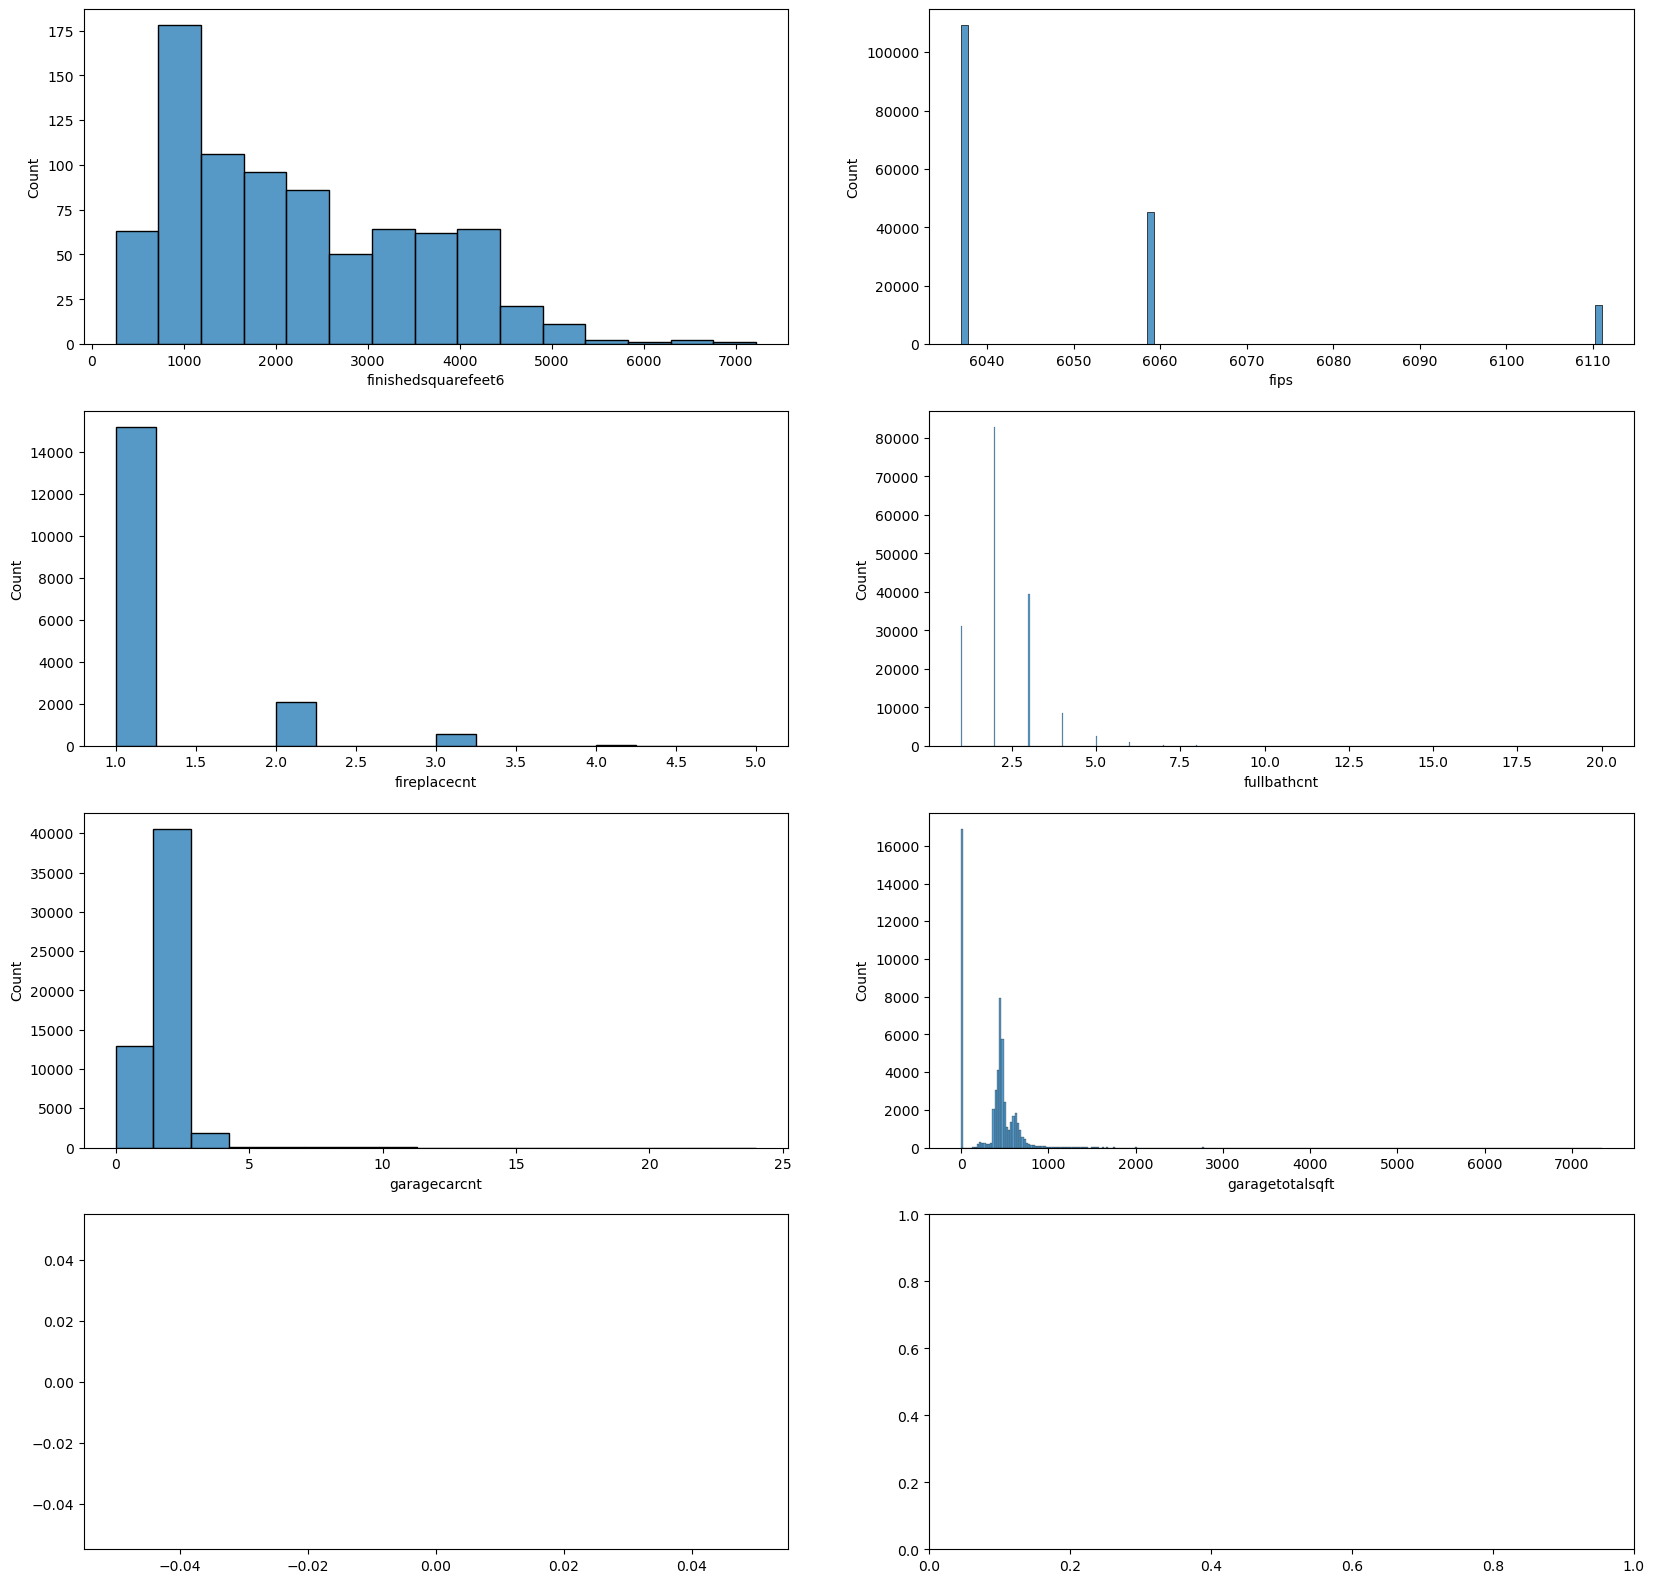

In [130]:
# Let's get a grid of next 8 features up and see what we find.
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))  # Make four rows of 2 plots.
for i, column in enumerate(all.columns[18:26]):
    sns.histplot(data=all, x=column, ax=axes[i // 2, i % 2])  # A bit of arithmatic to assign every figure to the correct subplot (axis).


In [108]:
# How many rows having missing values, by column?
missing_values = all.isna().sum()
missing_percentages = (missing_values / len(all)) * 100

miss_df = pd.concat([missing_values, missing_percentages], axis=1, keys=['Missing counts', 'Missing percentages'])
miss_df = miss_df.sort_values(['Missing percentages', 'Missing counts'], ascending=False)

miss_df = miss_df[miss_df['Missing percentages'] > 98]
miss_df


,Missing counts,Missing percentages
buildingclasstypeid,167857,99.981535
finishedsquarefeet13,167813,99.955327
basementsqft,167795,99.944606
storytypeid,167795,99.944606
yardbuildingsqft26,167723,99.901720
fireplaceflag,167494,99.765320
architecturalstyletypeid,167420,99.721243
typeconstructiontypeid,167366,99.689078
finishedsquarefeet6,167081,99.519322
decktypeid,166616,99.242352


In [97]:
# Drop all columns with missing values > 98%
all.drop(miss_df.index, axis=1, inplace=True)
all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 47 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   parcelid                      167888 non-null  int64         
 1   logerror                      167888 non-null  float64       
 2   transactiondate               167888 non-null  datetime64[ns]
 3   airconditioningtypeid         53788 non-null   float64       
 4   bathroomcnt                   167854 non-null  float64       
 5   bedroomcnt                    167854 non-null  float64       
 6   buildingqualitytypeid         107173 non-null  float64       
 7   calculatedbathnbr             166056 non-null  float64       
 8   finishedfloor1squarefeet      12893 non-null   float64       
 9   calculatedfinishedsquarefeet  166992 non-null  float64       
 10  finishedsquarefeet12          159519 non-null  float64       
 11  finishedsquar

<AxesSubplot: >

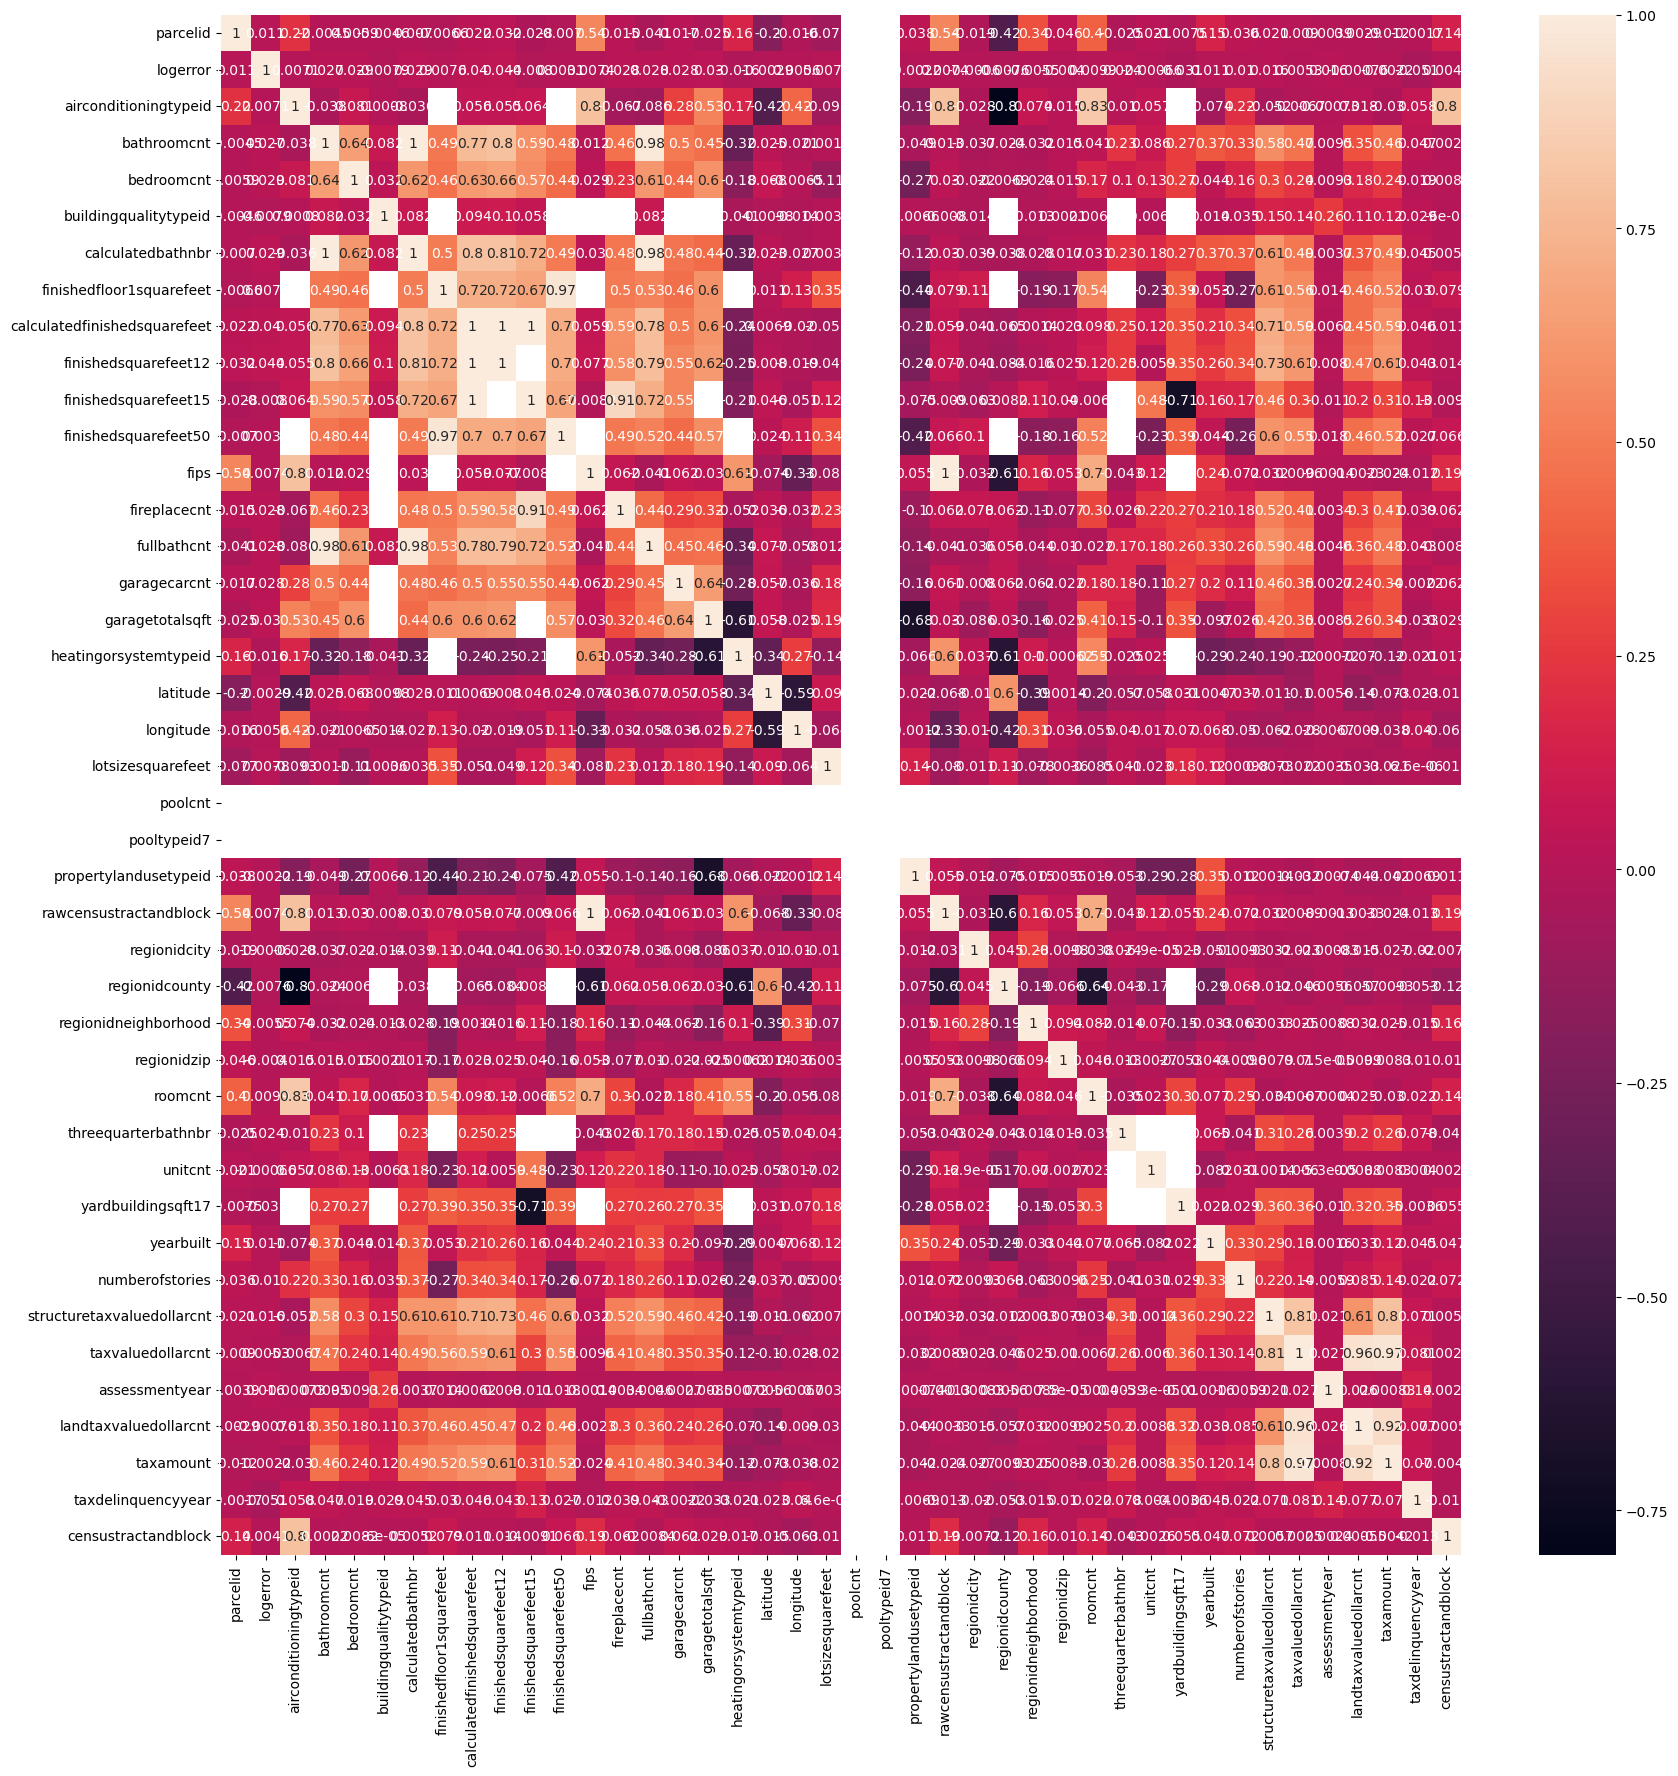

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation = all.corr()
correlation

plt.figure(figsize=(20,20))

sns.heatmap(correlation, annot=True)


In [102]:
correlation_features_list = correlation['logerror'].sort_values(ascending=False)
correlation_features_list

logerror                        1.000000
finishedsquarefeet12            0.043977
calculatedfinishedsquarefeet    0.039710
garagetotalsqft                 0.029616
calculatedbathnbr               0.029432
bedroomcnt                      0.028513
fireplacecnt                    0.028223
fullbathcnt                     0.028079
garagecarcnt                    0.027544
bathroomcnt                     0.027038
threequarterbathnbr             0.023777
assessmentyear                  0.016091
structuretaxvaluedollarcnt      0.015546
yearbuilt                       0.011364
parcelid                        0.010730
numberofstories                 0.010421
roomcnt                         0.009949
lotsizesquarefeet               0.007831
finishedfloor1squarefeet        0.007591
fips                            0.007406
rawcensustractandblock          0.007375
airconditioningtypeid           0.007077
longitude                       0.005644
taxvaluedollarcnt               0.005332
censustractandbl

In [103]:
# Drop all columns with no correlation with logerror -> poolcnt, pooltypeid7
all.drop(['poolcnt', 'pooltypeid7'], axis=1, inplace=True)
all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 45 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   parcelid                      167888 non-null  int64         
 1   logerror                      167888 non-null  float64       
 2   transactiondate               167888 non-null  datetime64[ns]
 3   airconditioningtypeid         53788 non-null   float64       
 4   bathroomcnt                   167854 non-null  float64       
 5   bedroomcnt                    167854 non-null  float64       
 6   buildingqualitytypeid         107173 non-null  float64       
 7   calculatedbathnbr             166056 non-null  float64       
 8   finishedfloor1squarefeet      12893 non-null   float64       
 9   calculatedfinishedsquarefeet  166992 non-null  float64       
 10  finishedsquarefeet12          159519 non-null  float64       
 11  finishedsquar

<AxesSubplot: >

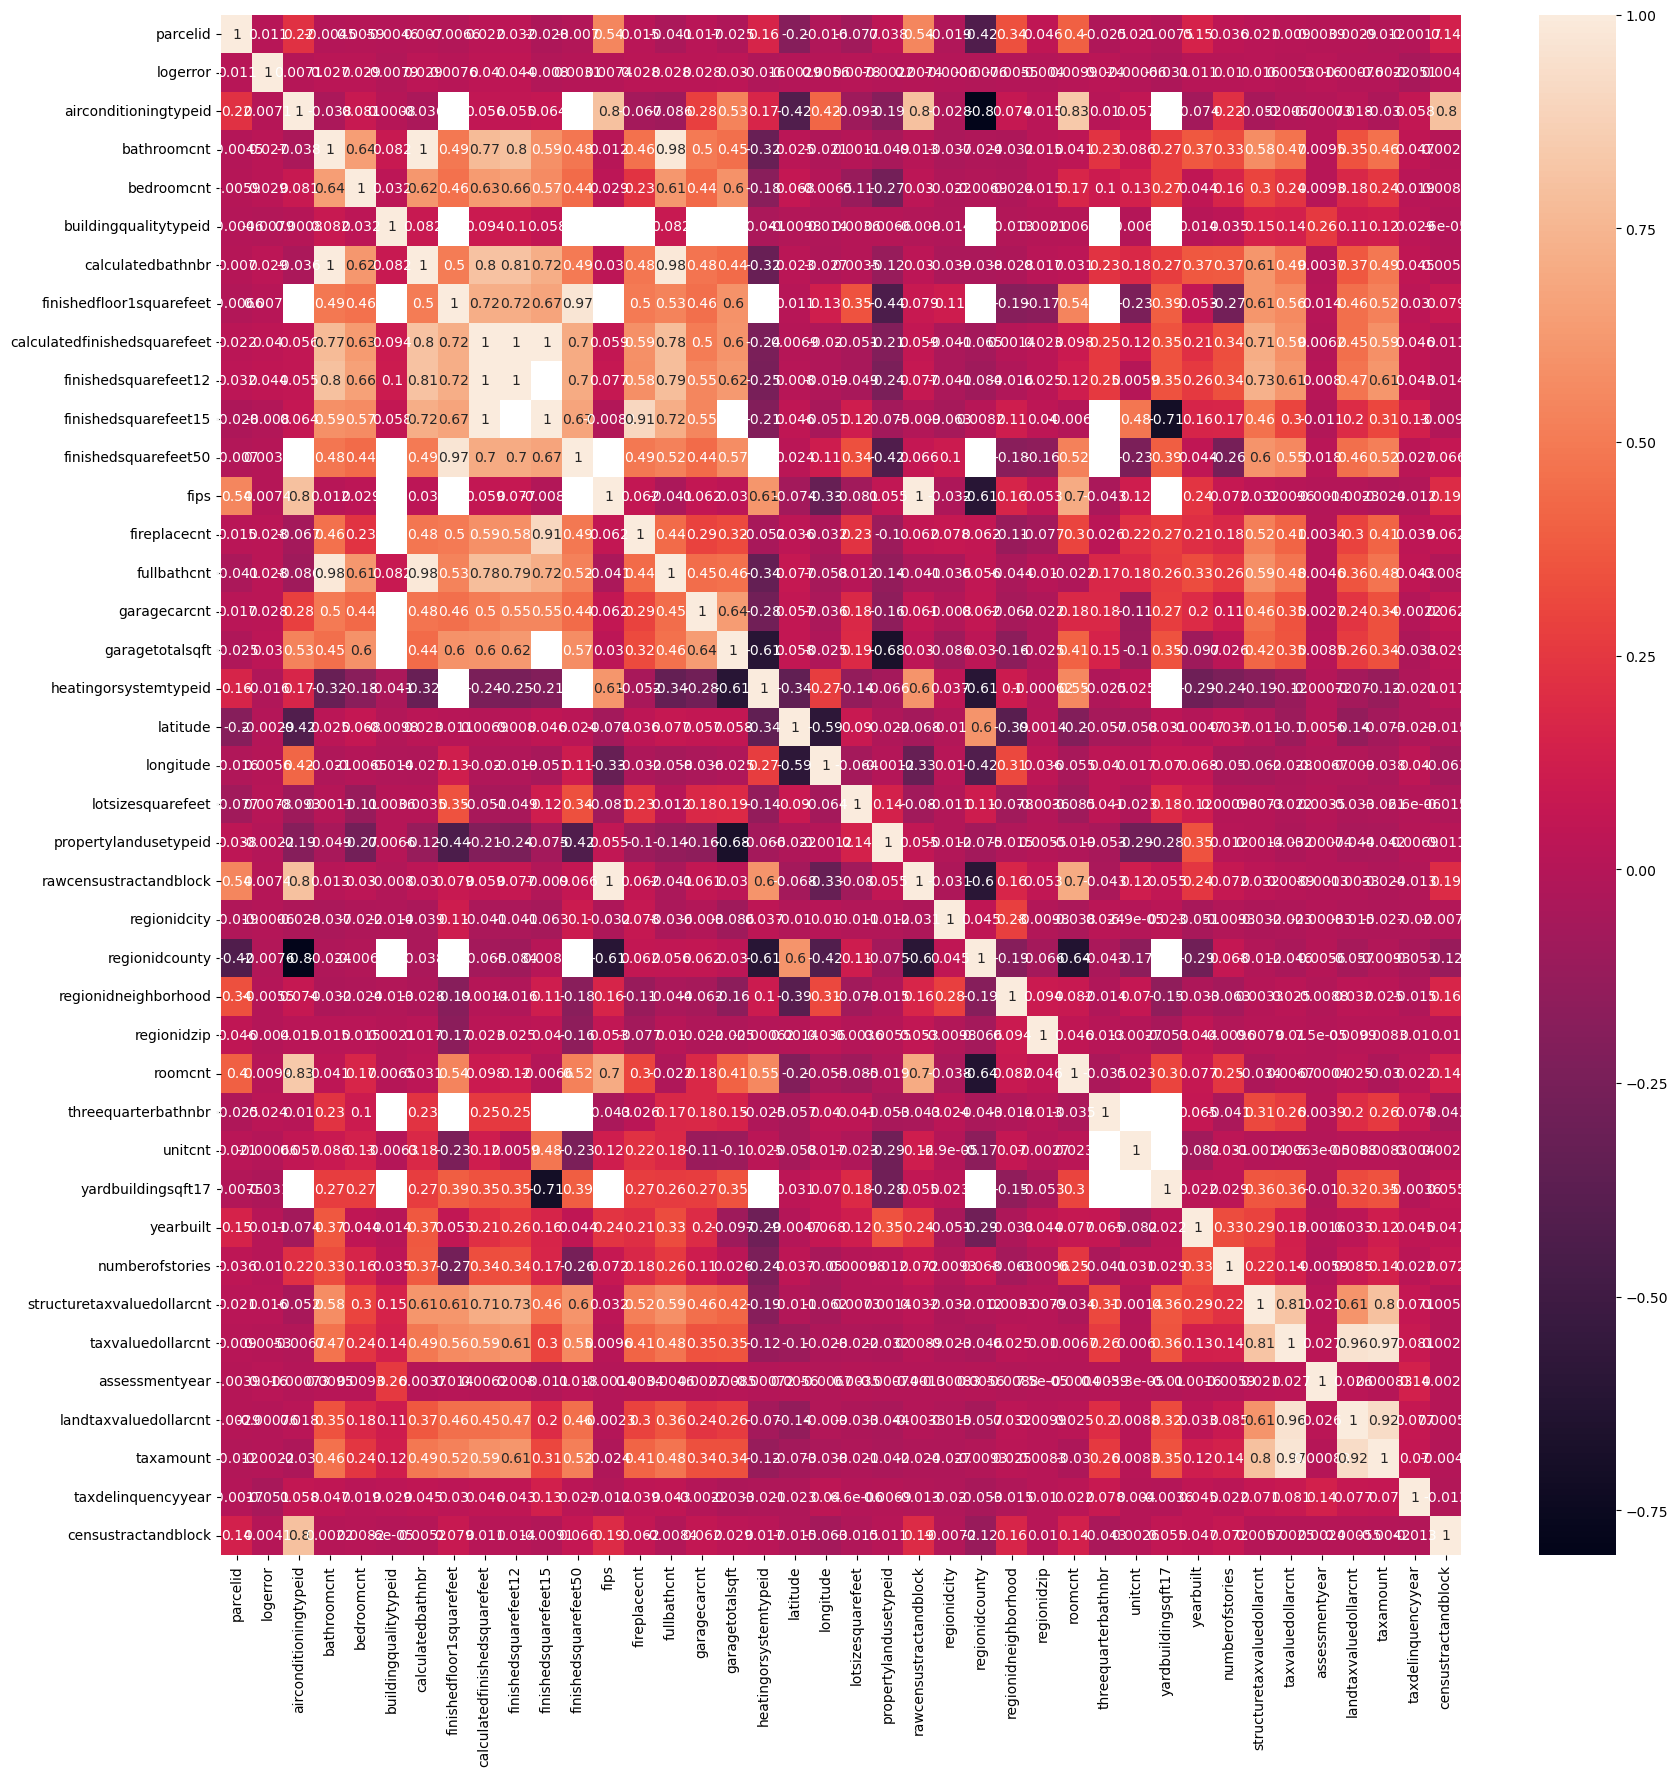

In [104]:
correlation = all.corr()
correlation

plt.figure(figsize=(20,20))

sns.heatmap(correlation, annot=True)

In [ ]:
# Split the concatenated dataframe into train and test dataframes
train, test = train_test_split(all, test_size=0.51, random_state=5, shuffle=True)

# Print the number of rows in each dataframe
print(f'Train shape: {train.shape}')
print(f'Test shape: {train.shape}')

In [ ]:
# Casting to Pandas categorical simplifies plotting later.

all['hashottuborspa'] = all['hashottuborspa'].map({0: "TRUE"})
all['propertycountylandusecode'] = pd.Categorical(all['propertycountylandusecode'])
all['propertyzoningdesc'] = pd.Categorical(all['propertyzoningdesc'])
all['fireplaceflag'] = all['fireplaceflag'].map({0: "TRUE"})
all['taxdelinquencyflag'] = all['taxdelinquencyflag'].map({0: "Y"})
